# Introduction

This project analyzes data from lendingclub.com from 2007 to 2015. Correctly predicting whether or not a loan will be a default is very important to lending companies. To ensure a smooth business transaction, lenders need to only do business with those are more likely to pay the loans back with interest in full. If the lendee fails to pay the loan, it can have significant impact on their credit score and makes it virtually impossible to secure loans in the future. The goal of this project is to create a prediction model to help complete this determination utilizing historical data. 

### Data Sources

load_data.csv was provided from https://www.kaggle.com/datasets/urstrulyvikas/lending-club-loan-data-analysis?resource=download

# Scoping 

This project will be broken down into four sections. The first section will be gathering insights on the data using pandas library. The second section will be cleaning the data for any duplicates or null values. Third section is for analyzing the data while providing insightful visualizations for communicating the findings. Last section will be model selection, optimization, and scoring. 

# Analysis

The final XGBoost model score against the test set can be visualized with the confusion matrix. The model scored a 98.9% accuracy which corresponds with the 20 inputs it mistakenly labeled. A heat map to show each feature tested correlation scores was provided for reference in deciding which ones would improve the models prediction power and which ones should be left out. 

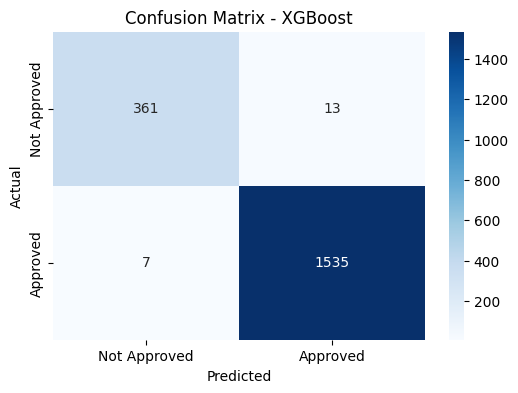
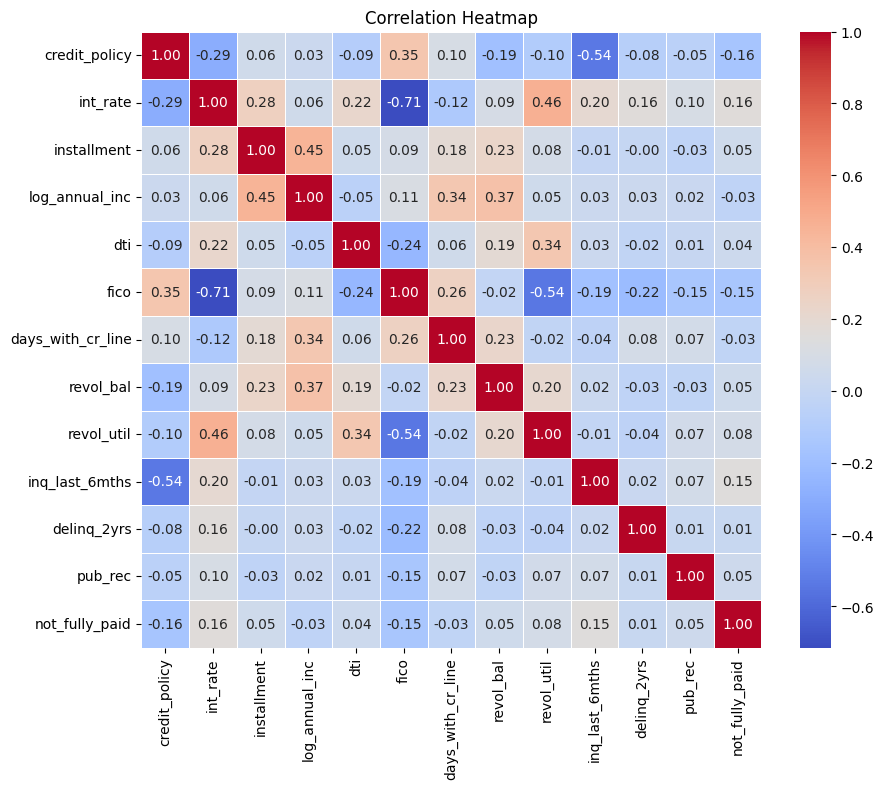

# Evaluation

The XGBoost model was selected after scoring a accuracy of 98.9%. Additionally the model scored a final precision score of 99.2%, recall score of 99.5%, and F1-score of 99.3%. These scores were emphasized showcasing the models ability to avoid type 1 errors. In simplier terms, the model was optimized to approve only those worthy and avoid approving those who do not fit the underwriting criteria. Other models considered was the Logistic Regression which scored a 90% accuracy and the Random Forest Classifier which scored a 98.8% accuracy both less than the XGBoost model.

The top 5 features that gave the model the most weight included:
1. Number of inquires on report in a 6 month span
2. The user's Fico Score
3. Amount of days with a credit line open
4. Debt to Income ratio
5. Revolving balance

These are also the top 5 most important indicators toward a borrower receiving or being denied a loan. Having a low amount of inquires from the last 6 months, a high Fico Score, extensive credit history, low debt-to-income ratio, and a low revolving balance gives you the best chance of being approved for a loan with lendingclub.com. 

## Importing Python Modules

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#loading the loan data
loans = pd.read_csv("loan_data.csv")

#Preview of top 5 rows. 
print(loans.head())

   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0   

## Column descriptions

credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.

purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").

int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.

installment: The monthly installments owed by the borrower if the loan is funded.

log.annual.inc: The natural log of the self-reported annual income of the borrower.

dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).

fico: The FICO credit score of the borrower.

days.with.cr.line: The number of days the borrower has had a credit line.

revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).

revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).

inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.

delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.

pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

The columns are listed with "." to seperate the column names. To avoid any confusion and mistakes while writing in python, next step will be iterating over the columns to replace the periods with "_" underscores instead. 

In [153]:
# create a empty capture list
new_columns = []
for column in loans.columns:
    new_columns.append(column.replace(".", "_"))

#Check for new changes
loans.columns = new_columns

print(loans.columns)
print(loans.head())

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')
   credit_policy             purpose  int_rate  installment  log_annual_inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days_with_cr_line  revol_bal  revol_util  inq_last_6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.

Continue to grab more information about the data. Define which columns are discrete and which are continuous. Are they in the right dtypes? 

In [154]:
#Central tendency and range
print(loans.describe())

       credit_policy     int_rate  installment  log_annual_inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.216400   940.140000       14.528354    29.960000   

              fico  days_with_cr_line     revol_bal   revol_util  \
count  9578.000000        9578.000000  9.578000e+03  9578.000000   
mean    710.846314        4560.767197  1.691396e+04    46.799236   
std      37.970537        2496.930377  3.375619e+04    29.014417   
min     612.0000

In [155]:
#Checking for null values and dtypes
print(loans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int_rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log_annual_inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days_with_cr_line  9578 non-null   float64
 8   revol_bal          9578 non-null   int64  
 9   revol_util         9578 non-null   float64
 10  inq_last_6mths     9578 non-null   int64  
 11  delinq_2yrs        9578 non-null   int64  
 12  pub_rec            9578 non-null   int64  
 13  not_fully_paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
None


Since each column has all its inputs we can dive into feature transformation. This will help with visualizations later and for inputing this column as a feature into the machine learning models. The "purpose" column has 5 selections to choose from with no particular order. For the nomial categorical variable, pandas has one-hot encoding that will not only create new columns for each selection, but also include a count for each. For simple visualization, the frequency will be displayed in the data visualization section. 

In [156]:
#one hot code to transform purpose column to numerical column
loans_encoded = pd.get_dummies(loans, drop_first=True)

# Data Analysis through Visualization

purpose
debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: count, dtype: int64


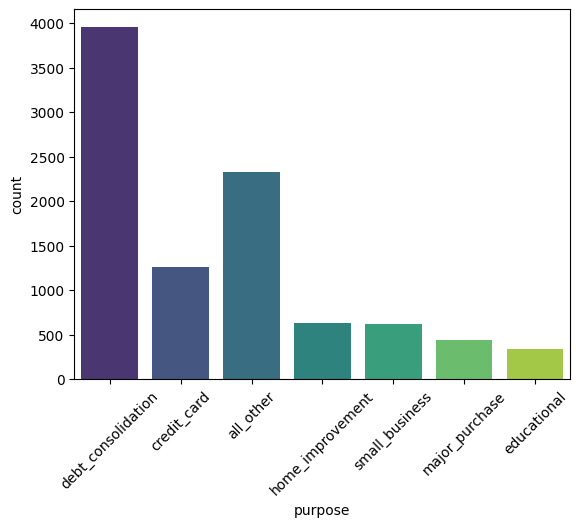

In [157]:
#Frequecy for each purpose. 
purposes = loans["purpose"].value_counts()
print(purposes)

#Create countplot with different colors for each category
sns.countplot(x=loans["purpose"], hue=loans["purpose"], palette="viridis")
plt.xticks(rotation=45)
plt.show()

Here debt consolidation is the number 1 reason most users are taking out loans at lendingclub.come while educational purposes is at the bottom. 

# Feature engineering

Next checking for correlation between the given features. Using a heatmap to check which features correlate with each other significantly and equip the model with them. 

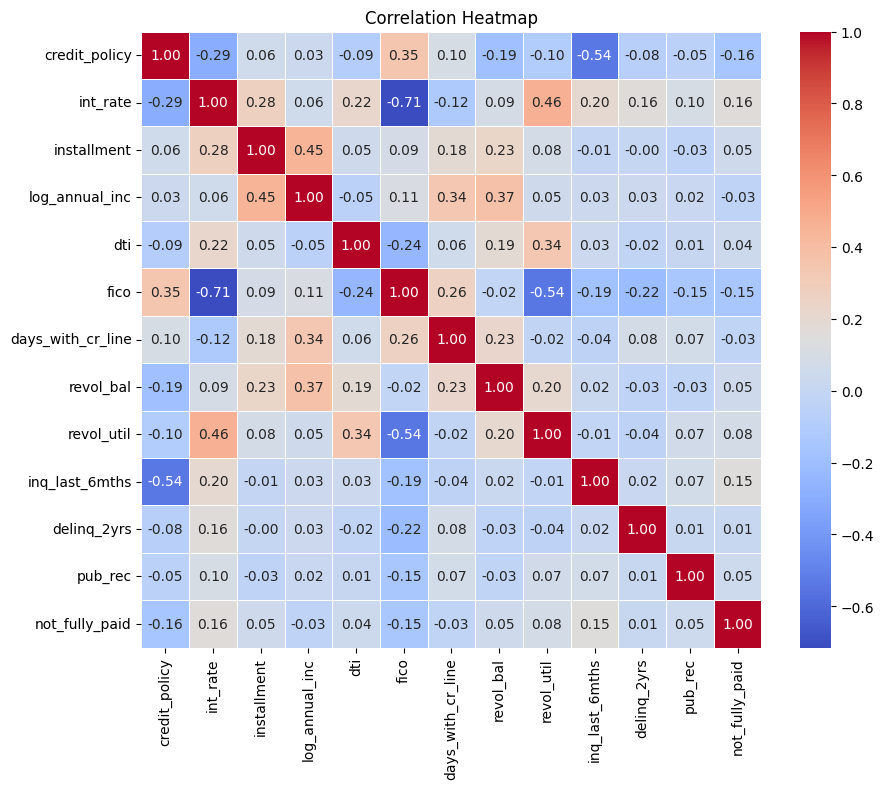

In [158]:
#Using .corr() to create correlation matrix
loans_matrix = loans.select_dtypes(include=['number']).corr()

#Creating heatmap with blue-red colorway.
plt.figure(figsize=(10,8))
sns.heatmap(loans_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show() 

Based on the heatmap, there are 4 features that stick out most that will be included in the model creation. Those features are "inq_last_6mths", "revol_util", "fico", and "int_rate". These 4 will be monitored to determine lendingclub's credit policy which is a boolean of 0 for not a liable partner and 1 (customer meets credit underwriting criteria).

# Model Selection and Optimization

Three models will be selected for classification utilizing the historical data provided: Logistic Regression, Random Forest Classifier, and XGBosst models. The data will be split on a 80:20 split for training and testing our models. The scores calculated and analysized for which machine gives the best classfiication with the least amount of bias without overfitting the models. 

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

#Using the encoded data from above
X = loans_encoded.drop(columns=["credit_policy"])
y = loans_encoded["credit_policy"]

#Split data (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #to ensure replicatable results, a random random_state was choosen. Stratify ensures that class proportions in the original datasets are preserved

#Standardize numeric features for a stronger Logisitc Regression (baseline model)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Logisitic Regression
log_reg = LogisticRegression(max_iter=500) #So the model does not iterate forever a max_iter was provided
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

#Accuracy test and classification report for Logisitc Regression Model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

#Accuracy test and classification report for Random Forest Classifier using default n_estimators
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# XGBoost Classifier
xgb_clf = XGBClassifier(eval_metric="logloss", n_estimators=100)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

#Accuracy test and classification report for XGBoost Classifier
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Logistic Regression Accuracy: 0.9091858037578288
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       374
           1       0.93      0.96      0.94      1542

    accuracy                           0.91      1916
   macro avg       0.87      0.83      0.85      1916
weighted avg       0.91      0.91      0.91      1916

Random Forest Classifier Accuracy: 0.988517745302714
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       374
           1       0.99      1.00      0.99      1542

    accuracy                           0.99      1916
   macro avg       0.99      0.97      0.98      1916
weighted avg       0.99      0.99      0.99      1916

XGBoost Accuracy: 0.9895615866388309
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       374
           1       0.99      1.00      0.99      1542

    accuracy                           0.99

The models scored very well on this dataset. XGBoost model scored the highest with a 98.9% accuracy only beating the Random Forest Classifier by 0.1%! The Logistic Regression Model was used as a baseline stating the data is particularly linear with a score of 90% accuracy. For ease of use, we will use the Random Forest Classifier and optimize is further to see if we can get 0.2% to take the overall accuracy to 99%. 

In [160]:
#Calculate counts correct with Confusion Matrix
from sklearn.metrics import confusion_matrix

rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)
print(rf_confusion_matrix)

[[ 355   19]
 [   3 1539]]


From the confusion matrix there is still work to be done to optimize this model in reducing 19 false positives and 3 false negatives. Let's check which features is the model adding most weight to.  

In [161]:
feature_imp = pd.DataFrame(zip(X_train.columns, rf_clf.feature_importances_), columns=['feature', 'importance'])
print('Most important to least random forest features:')
print(feature_imp.sort_values('importance', ascending=False))

Most important to least random forest features:
                       feature  importance
8               inq_last_6mths    0.398172
4                         fico    0.234126
5            days_with_cr_line    0.115143
6                    revol_bal    0.071163
3                          dti    0.063429
0                     int_rate    0.042243
7                   revol_util    0.025345
2               log_annual_inc    0.019420
1                  installment    0.015817
11              not_fully_paid    0.005099
9                  delinq_2yrs    0.002446
17      purpose_small_business    0.001484
15    purpose_home_improvement    0.001348
13  purpose_debt_consolidation    0.001324
12         purpose_credit_card    0.001263
10                     pub_rec    0.000848
14         purpose_educational    0.000820
16      purpose_major_purchase    0.000510


The top feature selected was the last 6 months of inquiries with the purposes being less viable features. Next step will involve reducing the features and setting a depth value for the model. 

In [162]:
#Creating a new features list including the top 9 listed from the default model. 
feature_col = list(feature_imp['feature'].iloc[0:9])

#Creating new train, test data on selected features for model
X_new = pd.get_dummies(loans[feature_col], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42, test_size=0.2, stratify=y)

#Create new scaled version
scaler1 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train)
X_test_scaled = scaler1.transform(X_test)


#Finding best max depth through accuracy test iteration
np.random.seed(0)
accuracy_train = []
accuracy_test = []
depths = range(1,26) #Testing a range of 1-25 for the max_depth
for i in depths:
    rf = RandomForestClassifier(max_depth=i, random_state=42, n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_test.append(accuracy_score(y_test, y_pred))
    accuracy_train.append(accuracy_score(y_train, rf.predict(X_train)))

#Using the accuracy score for test set find the best depth for the model.
acc_best = np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print("Best accuracy score for test set:", acc_best)
print("Best max_depth for model:", best_depth) 

Best accuracy score for test set: 0.9890396659707724
Best max_depth for model: 20


Best score for the model was a 98.9% were the XGBoost still had 0.05% higher score. Next step will be visualizing the training score versus the test score. Last, a confusion matrix will be used to see if any significant improvements were made by optimizing this models max_depth to a 20. 

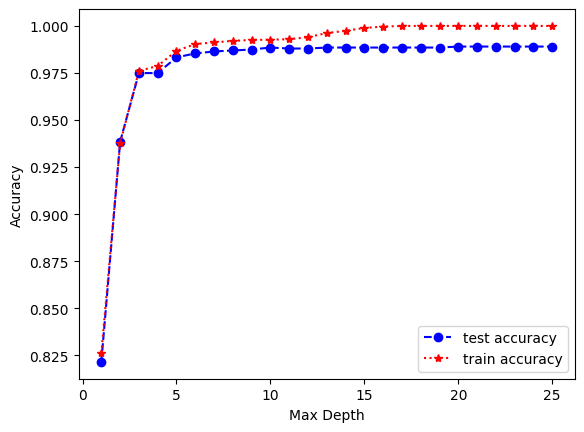

Confusion Matrix for max depth 20: [[ 357   17]
 [   4 1538]]


In [163]:
plt.plot(depths, accuracy_test, 'bo--',depths, accuracy_train, 'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

#Confusion matrix for best depth model
best_rfc = RandomForestClassifier(max_depth=best_depth, random_state=42, n_estimators=100)
best_rfc.fit(X_train, y_train)
best_rfc_pred = best_rfc.predict(X_test)
best_rfc_con_matrix = confusion_matrix(y_test, best_rfc_pred)
print("Confusion Matrix for max depth 20:",best_rfc_con_matrix)

With this optimized model, the False Positve reduced by 2 but the False negative increased by 1. In simplier terms, the model improved on classifying those who were to be rejected for the loan but missed one extra person who was qualified but was marked "not qualified" by the model. Since XGBoost model is still superior, next step will be laying out the importance of the features it used and creating a visualization for it's accuracy. 

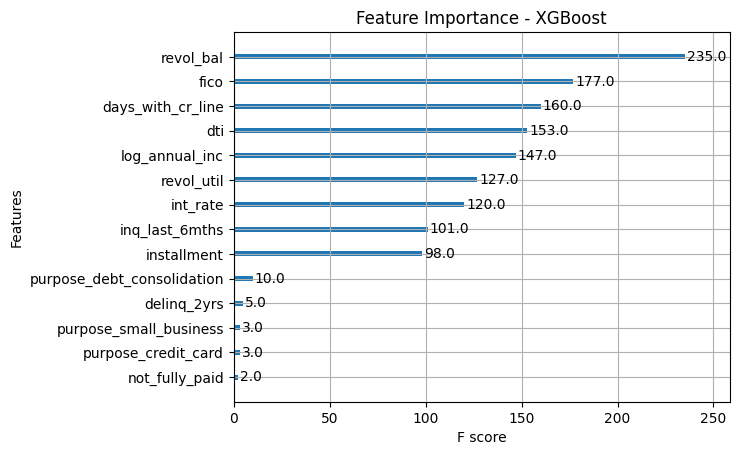

In [164]:
import xgboost as xgb

xgb.plot_importance(xgb_clf)
plt.title("Feature Importance - XGBoost")
plt.show()

XGBoost carried the highest weight on the revolving line balance over the last 6 months of inquires like the Random Forest Classifier did. Again, the purpose categories were viewed as less important of a feature compared to the rest. Next lets use a heatmap to showcase the confusion matrix. 

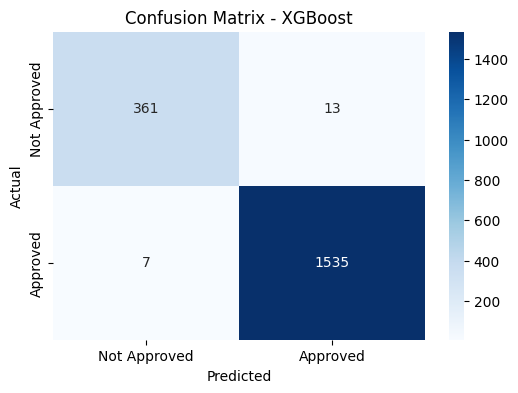

In [165]:
#A predictor variable was created previously "y_pred_xgb". Plugging it into a confusion matrix. 
cm = confusion_matrix(y_test, y_pred_xgb)

#Plotting confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

The XGBoost model is better at predicting who should not be approved according to lendingclub.com's credit underwriting criteria. Although the model predicted 7 users to be rejected when they were actually suppose to be approved would help a company out better than a model making a type 1 mistake and predicting users to be approved when they do not meet the criteria. For final test and visualization method to showcase the models precision and recall scores (effectiveness against type 1 errors) a Roc curve will be provided.  

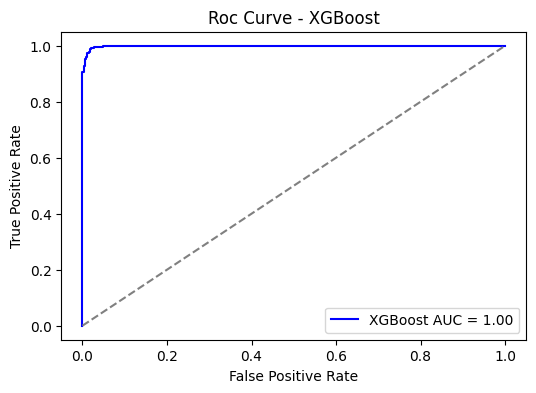

In [166]:
from sklearn.metrics import roc_curve, auc

#Including filtered columns, xgb model must be retrained on scaled data. 
xgb_clf.fit(X_train_scaled, y_train)
#Get probabilities for the positive class
y_prob_xgb = xgb_clf.predict_proba(X_test_scaled)[:,1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost AUC = {roc_auc:.2f}') 
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve - XGBoost')
plt.legend()
plt.show()

A 1.00 AUC score is solid but can be misleading. To fine tune this model, hyparameters need to be tuned. Instead of doing it by hand, let RandomizedSearchCV do the tuning. Due to a high amount of loans being approved over those denied, there could be an imbalance in classes. To deal with this, the model will be introduced to a "weighted scale" for the classification. Also have to consider overfitting the model on the training data. The model will be scored on F1 since precision and recall both reduce the potential for approving non=credited users.  

In [167]:
from sklearn.model_selection import RandomizedSearchCV

#Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'scale_pos_weight': [1, 5, 10]  # Useful if classes are imbalanced
}

# Initialize XGBoost model
xgb_clf_opt = xgb.XGBClassifier(eval_metric="logloss")

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_clf_opt, param_distributions=param_grid, n_iter=20, 
    scoring='f1', cv=5, verbose=2, n_jobs=-1
)

# Fit model
random_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", random_search.best_params_)

# Capture best model
best_xgb = random_search.best_estimator_
print(best_xgb)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)


Using the new hyperparameters, a new ROC Curve will be plotted. Followed by a classification report and confusion matrix. 

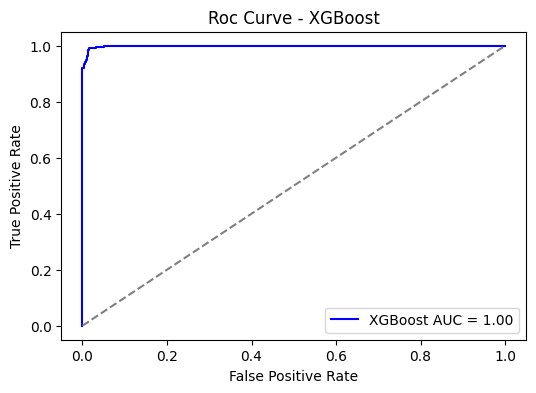

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       374
           1       0.99      0.99      0.99      1542

    accuracy                           0.99      1916
   macro avg       0.99      0.98      0.98      1916
weighted avg       0.99      0.99      0.99      1916



<Figure size 640x480 with 0 Axes>

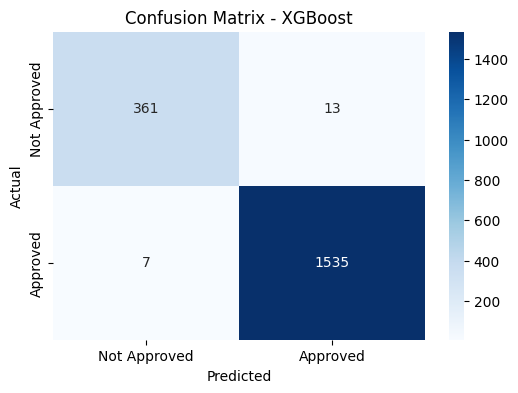

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

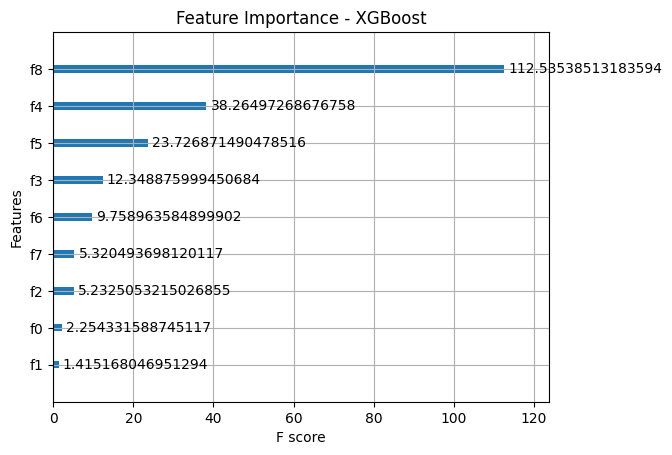

             Feature  Importance
8     inq_last_6mths  112.535385
4               fico   38.264973
5  days_with_cr_line   23.726871
3                dti   12.348876
6          revol_bal    9.758964
7         revol_util    5.320494
2     log_annual_inc    5.232505
0           int_rate    2.254332
1        installment    1.415168


<Figure size 640x480 with 0 Axes>

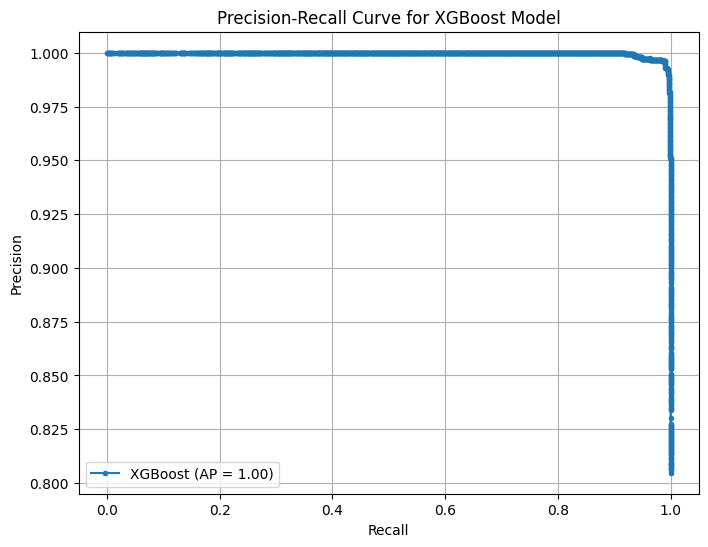

Final Accuracy Score: 0.9895615866388309
Final Precision Score: 0.9922380336351876
Final Recall Score: 0.9948119325551232
Final F1 Score: 0.9935233160621761


In [169]:
#Fit train model
best_xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
y_pred_best_xgb = best_xgb.predict(X_test_scaled)
#Get probabilities for the positive class
y_prob_best_xgb = best_xgb.predict_proba(X_test_scaled)[:,1]

# Compute ROC curve and AUC
fpr1, tpr1, _ = roc_curve(y_test, y_prob_best_xgb)
roc_auc = auc(fpr1, tpr1)

# Plotting ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr1, tpr1, color='blue', label=f'XGBoost AUC = {roc_auc:.2f}') 
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve - XGBoost')
plt.legend()
plt.show()
plt.clf()

print(classification_report(y_test, y_pred_best_xgb))
cm_final = confusion_matrix(y_test, y_pred_best_xgb)

#Plotting confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()
plt.clf()

#Plotting feature importance
plt.figure(figsize=(8,6))
xgb.plot_importance(best_xgb, importance_type='gain')
plt.title("Feature Importance - XGBoost")
plt.show()
plt.clf()

# Extract feature importance scores
feature_importance = best_xgb.get_booster().get_score(importance_type='gain')

# Convert to DataFrame for readability
importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance'])

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Map feature importance scores to actual feature names
feature_names = X.columns.tolist()  
feature_mapping = {f"f{i}": feature_names[i] for i in range(len(feature_names))}

# Rename features in DataFrame
importance_df['Feature'] = importance_df['Feature'].map(feature_mapping)

# Display the legend
print(importance_df)


#Plotting Precision over recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob_best_xgb)

# Average precision score
ap_score = average_precision_score(y_test, y_prob_best_xgb)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'XGBoost (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show()

print("Final Accuracy Score:", accuracy_score(y_test, y_pred_best_xgb))
print("Final Precision Score:", precision_score(y_test, y_pred_best_xgb))
print("Final Recall Score:", recall_score(y_test, y_pred_best_xgb))
print("Final F1 Score:", f1_score(y_test, y_pred_best_xgb))

# Conclusion

In this project, the goal was to select and optimize a model that could help lendingclub.com, and potentially other lending services, in crafting a learning model to predict whether or not a user meets the underwriting credit lending criteria. After diving through the data from 2007 - 2015, the XGBoost model was selected after scoring a accuracy of 98.9% and a final: precision score of 99.2%, recall score of 99.5%, and F1-score of 99.3%. These scores were emphasized showcasing the models ability to avoid type 1 errors. In simplier terms, the model was optimized to approve only those worthy and avoid approving those who do not fit the underwriting criteria. Other models considered was the Logistic Regression which scored a 90% accuracy and the Random Forest Classifier which scored a 98.8% accuracy both less than the XGBoost model.   